# Перемешиваем модальности

# Metadata
transforms, model+optimizer+loss, hyperparams

In [1]:
TITLE = "int+flip, contextnet-SegResNetDS+adan+dicefocal"

# Imports

In [2]:
from glio.imports import *
from glio.importsglio import *

from glio.datasets.mri_preloaded import *
from glio.specific.mri_around import *
from glio.specific.vkr import *
from glio.transforms.intensity import RandScale, RandShift
from glio.transforms.spatial import RandFlipt

from glio.torch_tools import ConcatZeroChannelsToDataloader, BatchInputTransforms

d:\miniconda3\envs\pytorch311\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Dataset

In [3]:
bratstrain = get_ds_around(BRATS2024_NOHIST96_TRAIN) + get_ds_around(BRATS2024_NOHIST96_TEST)
rhuhtest = get_ds_around(RHUH_NOHIST140_NOADC_TRAIN) + get_ds_around(RHUH_NOHIST140_NOADC_TEST)

In [4]:

from monai import transforms as mtf

# fast tfms
gaussianblur = mtf.RandGaussianSmooth(prob=0.1) # type:ignore
contrast = mtf.RandAdjustContrast(gamma = (0.5, 2), prob=0.1) # type:ignore

# slower tfms
biasfield = mtf.RandBiasField(prob=0.1) # type:ignore
hist_shift = mtf.RandHistogramShift(prob=0.05) # type:ignore
gibbs = mtf.RandGibbsNoise(prob=0.1) # type:ignore
riccan = mtf.RandRicianNoise(std=0.5, prob=0.05) # type:ignore

# very slow
kspike = mtf.RandKSpaceSpikeNoise(prob=0.1) # type:ignore

def rand_shuffle_channels_around(x:torch.Tensor, channels_per = 3):
    if random.random() < 0.1:
        num_groups = int(x.shape[0] / channels_per)
        perm = torch.randperm(num_groups, dtype=torch.int32)
        img= x.reshape(num_groups, channels_per, *x.shape[1:])[perm].flatten(0, 1)
        return img
    return x

def rand_group_dropout(x):
    if random.random() < 0.05: return torch.zeros_like(x)
    if random.random() < 0.05: return torch.randn_like(x)
    return x

def randnoise(x):
    if random.random() < 0.1: return x + torch.randn_like(x) * random.triangular(0, 0.5, 0)
    return x


In [5]:
dstrain = DSToTarget(0)
dstest = DSToTarget(0)

dstrain.add_samples(bratstrain, loader_around_seq_fix, RandFlipt(p=0.5), [get0, rand_shuffle_channels_around, GroupwiseTfms((randnoise, RandScale(p=0.3), RandShift(p=0.3), rand_group_dropout))], get1)
dstest.add_samples(rhuhtest, loader_around_seq, randcrop, get0, get1)
print(len(dstrain))
print(len(dstest))

332625
20893


# Performance

In [6]:
x = torch.randn((3,96,96))
with perf_counter_context():
    for i in range(100):
        dstrain[i]

Context took 0.4443432000116445 perf_counter seconds


# Inputs / targets preview

(<Figure size 2400x2400 with 4 Axes>,
 array([[<Axes: title={'center': 'inputs'}>,
         <Axes: title={'center': 'targets'}>],
        [<Axes: title={'center': 'inputs - test'}>,
         <Axes: title={'center': 'targets - test'}>]], dtype=object))

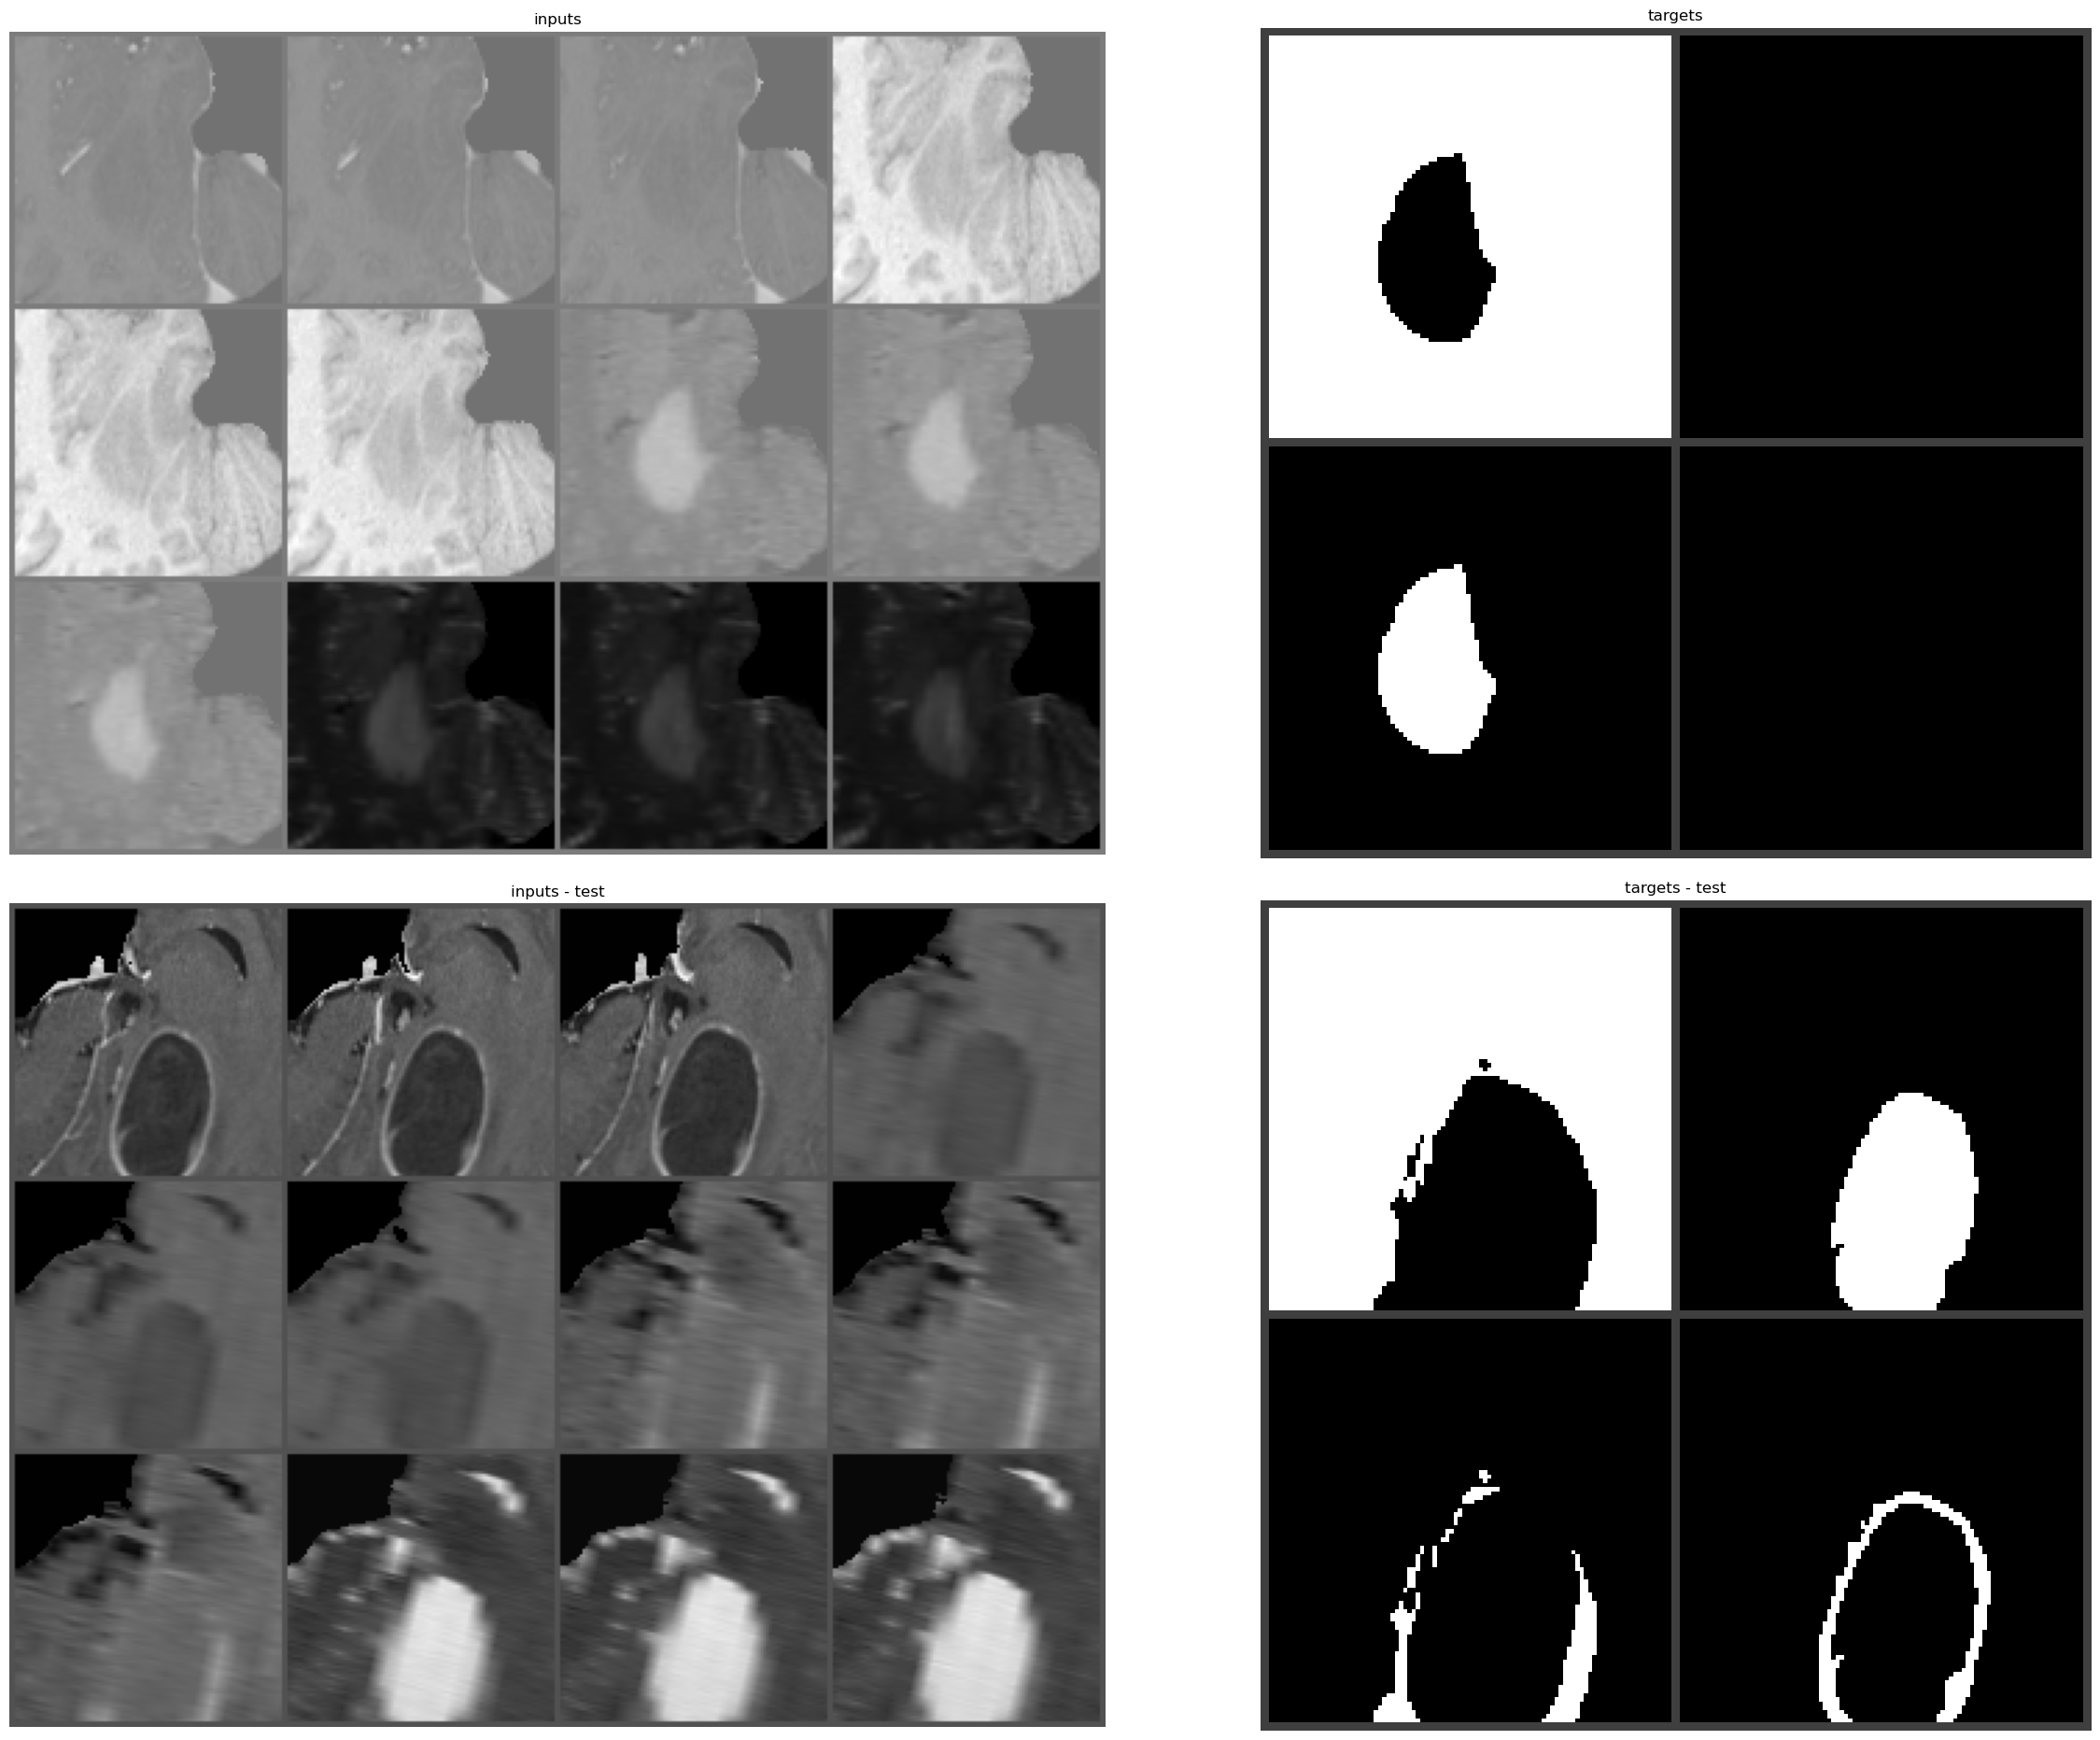

In [7]:
fig = Figure()
sample_ = dstrain[300]
fig.add().imshow_batch(sample_[0]).style_img('inputs')
fig.add().imshow_batch(sample_[1]).style_img('targets')
sample_ = dstest[20]
fig.add().imshow_batch(sample_[0]).style_img('inputs - test')
fig.add().imshow_batch(sample_[1]).style_img('targets - test')
fig.create(2, figsize=(24,24))

# Model

In [8]:
from monai.networks.nets import HighResNet # type:ignore
def HighResNet_noReLUattheend(in_channels=12, out_channels=20):
    model = HighResNet(2, in_channels, out_channels)
    model.blocks[-1].adn = nn.Identity()
    return model

single_tfms = Compose(rand_shuffle_channels_around, GroupwiseTfms((randnoise, RandScale(p=0.3, val=(0.75, 1.5)), RandShift(p=0.3, val=(-0.3, 0.3)), rand_group_dropout)))
batch_tfms = torch.vmap(single_tfms, randomness='different')

mse = torch.nn.MSELoss()

class ContextHRN(nn.Module):
    def __init__(self):
        super().__init__()
        self.batch_tfms = nn.Identity()
        self.hrn = HighResNet_noReLUattheend(12, 20)

    def forward(self, x:torch.Tensor):
        self.tfmed = self.batch_tfms(x)
        self.processed = self.hrn(self.tfmed)
        #loss = mse(self.processed[:, :12], x)
        return self.processed


contextnet = ContextHRN()
contextnet.load_state_dict(torch.load(r"F:\Stuff\Programming\experiments\vkr\training\RHUH full + BRATS-small test as test, 32\checkpoints\int+flip, contextnet+adan+dicefocal lr1e-01 OneCycleLR\2. 29.05.2024 11-00-54 (6-4571; testloss=0.69167; testacc=0.95965)\model.pt"))

FileNotFoundError: [Errno 2] No such file or directory: 'F:\\Stuff\\Programming\\experiments\\vkr\\training\\RHUH full + BRATS-small test as test, 32\\checkpoints\\int+flip, contextnet+adan+dicefocal lr1e-01 OneCycleLR\\2. 29.05.2024 11-00-54 (6-4571; testloss=0.69167; testacc=0.95965)\\model.pt'

In [ ]:
from monai.networks.nets import SegResNetDS # type:ignore
class ContextSegResNetDS(nn.Module):
    def __init__(self):
        super().__init__()
        self.context_block = ContextHRN()
        self.context_block.load_state_dict(torch.load(r"F:\Stuff\Programming\experiments\vkr\training\RHUH full + BRATS-small test as test, 32\checkpoints\int+flip, contextnet+adan+dicefocal lr1e-01 OneCycleLR\2. 29.05.2024 11-00-54 (6-4571; testloss=0.69167; testacc=0.95965)\model.pt"))
        self.net = SegResNetDS(2, 32, 32, 4)
    def forward(self, x:torch.Tensor):
        self.context = self.context_block(x)
        return self.net(torch.cat((x, self.context), 1))
print(f"{count_parameters(ContextSegResNetDS()) = }")

summary(ContextSegResNetDS(), (4, 12, 96, 96))

count_parameters(ContextSegResNetDS()) = 6928676
path                                         module                                       input size               output size              params    buffers   
__main__.ContextSegResNetDS/context_block/batch_tfmstorch.nn.modules.linear.Identity             (4, 12, 96, 96)          (4, 12, 96, 96)          0         0         
__main__.ContextSegResNetDS/context_block/hrn/blocks/0/convtorch.nn.modules.conv.Conv2d                 (4, 12, 96, 96)          (4, 16, 96, 96)          1728      0         
__main__.ContextSegResNetDS/context_block/hrn/blocks/0/adn/Ntorch.nn.modules.batchnorm.BatchNorm2d       (4, 16, 96, 96)          (4, 16, 96, 96)          32        33        
__main__.ContextSegResNetDS/context_block/hrn/blocks/0/adn/Atorch.nn.modules.activation.ReLU             (4, 16, 96, 96)          (4, 16, 96, 96)          0         0         
__main__.ContextSegResNetDS/context_block/hrn/blocks/1/layers/0/Ntorch.nn.modules.batchnorm.Bat

# Train

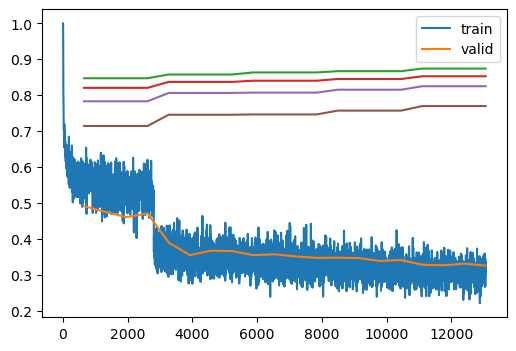

time: min: 8.1587; max: 13012.1769; last: 13012.1769
lr: min: 0.0000; max: 0.0020; last: 0.0000
train loss: min: 0.2218; max: 1.6154; last: 0.2713
train iou: min: 0.0030; max: 0.9724; last: 0.9555
train average precision: min: 0.2451; max: 0.4171; last: 0.3106
train roc auc: min: 0.3939; max: 0.7792; last: 0.6321
test loss: min: 0.3264; max: 0.4918; last: 0.3264
test iou: min: 0.8912; max: 0.9847; last: 0.9227
test average precision: min: 0.2472; max: 0.3163; last: 0.2589
test roc auc: min: 0.4684; max: 0.6607; last: 0.5118
test sensitivity: min: 0.7343; max: 0.7819; last: 0.7819
test specificity: min: 0.9570; max: 0.9663; last: 0.9663
test precision: min: 0.8831; max: 0.8932; last: 0.8932
test negative predictive value: min: 0.9766; max: 0.9805; last: 0.9805
test miss rate: min: 0.2181; max: 0.2657; last: 0.2181
test fall out: min: 0.0337; max: 0.0430; last: 0.0337
test false discovery rate: min: 0.1068; max: 0.1169; last: 0.1068
test false omission rate: min: 0.0195; max: 0.0234; las

In [ ]:
from stuff.found.torch.optim.Adan import Adan
from monai.losses import DiceFocalLoss # type:ignore

MODEL = ContextSegResNetDS()
NAME = f"{MODEL.__class__.__name__}"
LR = 2e-3
BATCH_SIZE = 32
N_EPOCHS = 10

# dl_train = DataLoader(ds_train, BATCH_SIZE)
dltrain = DataLoader(dstrain, BATCH_SIZE, shuffle=True)
dltest = DataLoader(dstest, BATCH_SIZE)

OPT = Adan(MODEL.parameters(), lr=LR)
LOSS_FN = DiceFocalLoss(softmax=True)
SCHED = lr_scheduler.OneCycleLR(OPT, max_lr=LR, steps_per_epoch=len(dltrain), epochs=N_EPOCHS)

clean_mem()
# MODEL = gnn.LSUV(MODEL, dltrain, max_iter=10)

CALLBACKS =  (Metric_Loss(),
              Log_Time(), Save_Best(), Save_Last(), Log_LR(), PerformanceTweaks(True), Accelerate("no"),
              MONAI_IoU(4, True, True, step=32, name='iou'),
              Torcheval_AURPC(4, True, step=32),
              Torcheval_AUROC(4, True, step=32),
              MONAI_ConfusionMatrix(step=4), MONAI_ConfusionMatrixMetrics(),
              MONAI_ConfusionMatrix(step=4, include_bg = False, name="nobg confusion matrix"), MONAI_ConfusionMatrixMetrics(key = 'nobg confusion matrix', prefix='nobg '),
              FastProgressBar(step_batch=128, plot=True, metrics=('train loss', 'test loss', 
                                                                  'test balanced accuracy', 'test nobg balanced accuracy',
                                                                  'test f1 score', 'test nobg f1 score'), maxv=1),
              Summary(),
              PlotSummary(path='summaries'),
              PrintLoss(),
              SaveReferenceVisualizationsAfterEachEpoch('reference preds'),
              #Metric_PredsTargetsFn(LOSS_FN, name='dice loss'),
              #CallTrainAndEvalOnOptimizer(),
              #AddLossReturnedByModelToLossInBackward(),
            )

LEARNER_NAME = f"{TITLE} lr{LR:.0e} OneCycleLR"
learner = Learner(MODEL, LEARNER_NAME,
                  cbs = CALLBACKS,
                  loss_fn=LOSS_FN,
                  optimizer=OPT,
                  scheduler=SCHED,)
learner.fit(N_EPOCHS, dltrain, dltest, test_first=False, test_on_interrupt=False)
plt.show()


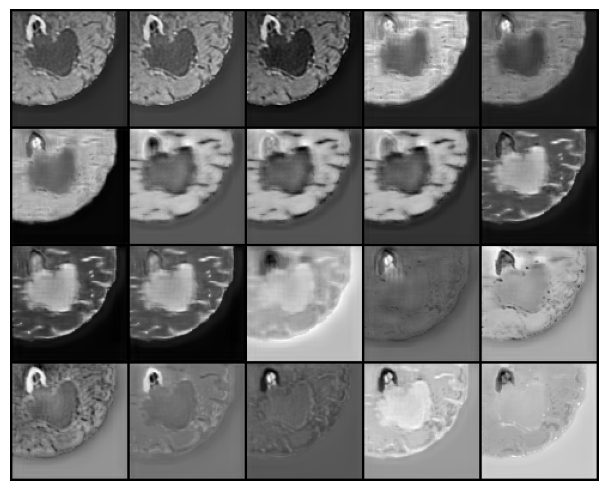

In [ ]:
qimshow_batch(learner.model.context[14], scale_each=True, maxelems=100)

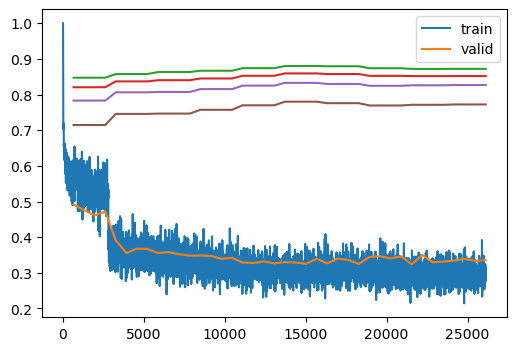

time: min: 8.1587; max: 27870.9439; last: 27870.9439
lr: min: 0.0000; max: 0.0020; last: 0.0000
train loss: min: 0.2145; max: 1.6154; last: 0.2497
train iou: min: 0.0030; max: 0.9769; last: 0.9619
train average precision: min: 0.2451; max: 0.4343; last: 0.3058
train roc auc: min: 0.3598; max: 0.7920; last: 0.6991
test loss: min: 0.3241; max: 0.4918; last: 0.3351
test iou: min: 0.8868; max: 0.9847; last: 0.9744
test average precision: min: 0.2472; max: 0.3341; last: 0.2766
test roc auc: min: 0.4225; max: 0.7200; last: 0.5522
test sensitivity: min: 0.7343; max: 0.7917; last: 0.7804
test specificity: min: 0.9570; max: 0.9695; last: 0.9639
test precision: min: 0.8831; max: 0.8978; last: 0.8978
test negative predictive value: min: 0.9766; max: 0.9820; last: 0.9820
test miss rate: min: 0.2083; max: 0.2657; last: 0.2196
test fall out: min: 0.0305; max: 0.0430; last: 0.0361
test false discovery rate: min: 0.1022; max: 0.1169; last: 0.1022
test false omission rate: min: 0.0180; max: 0.0234; las

In [22]:
LR = 5e-4
OPT = Adan(learner.model.parameters(), lr=LR)
SCHED = lr_scheduler.OneCycleLR(OPT, max_lr=LR, steps_per_epoch=len(dltrain), epochs=N_EPOCHS)
learner.fit(N_EPOCHS, dltrain, dltest, test_first=False, test_on_interrupt=False, extra=(Set_Optimizer(OPT), Set_Scheduler(SCHED)))

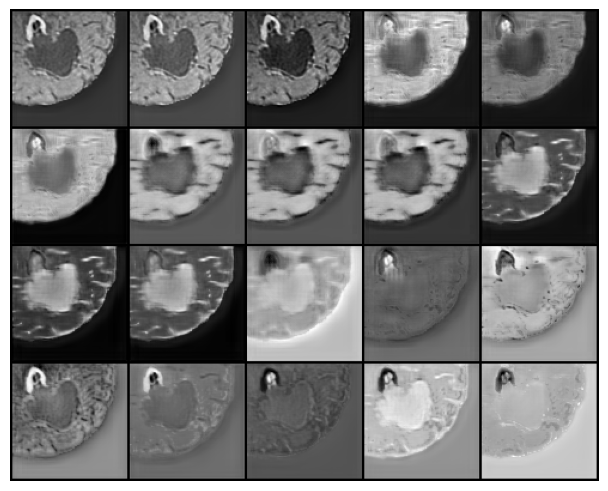

In [27]:
qimshow_batch(learner.model.context[14], scale_each=True, maxelems=100)

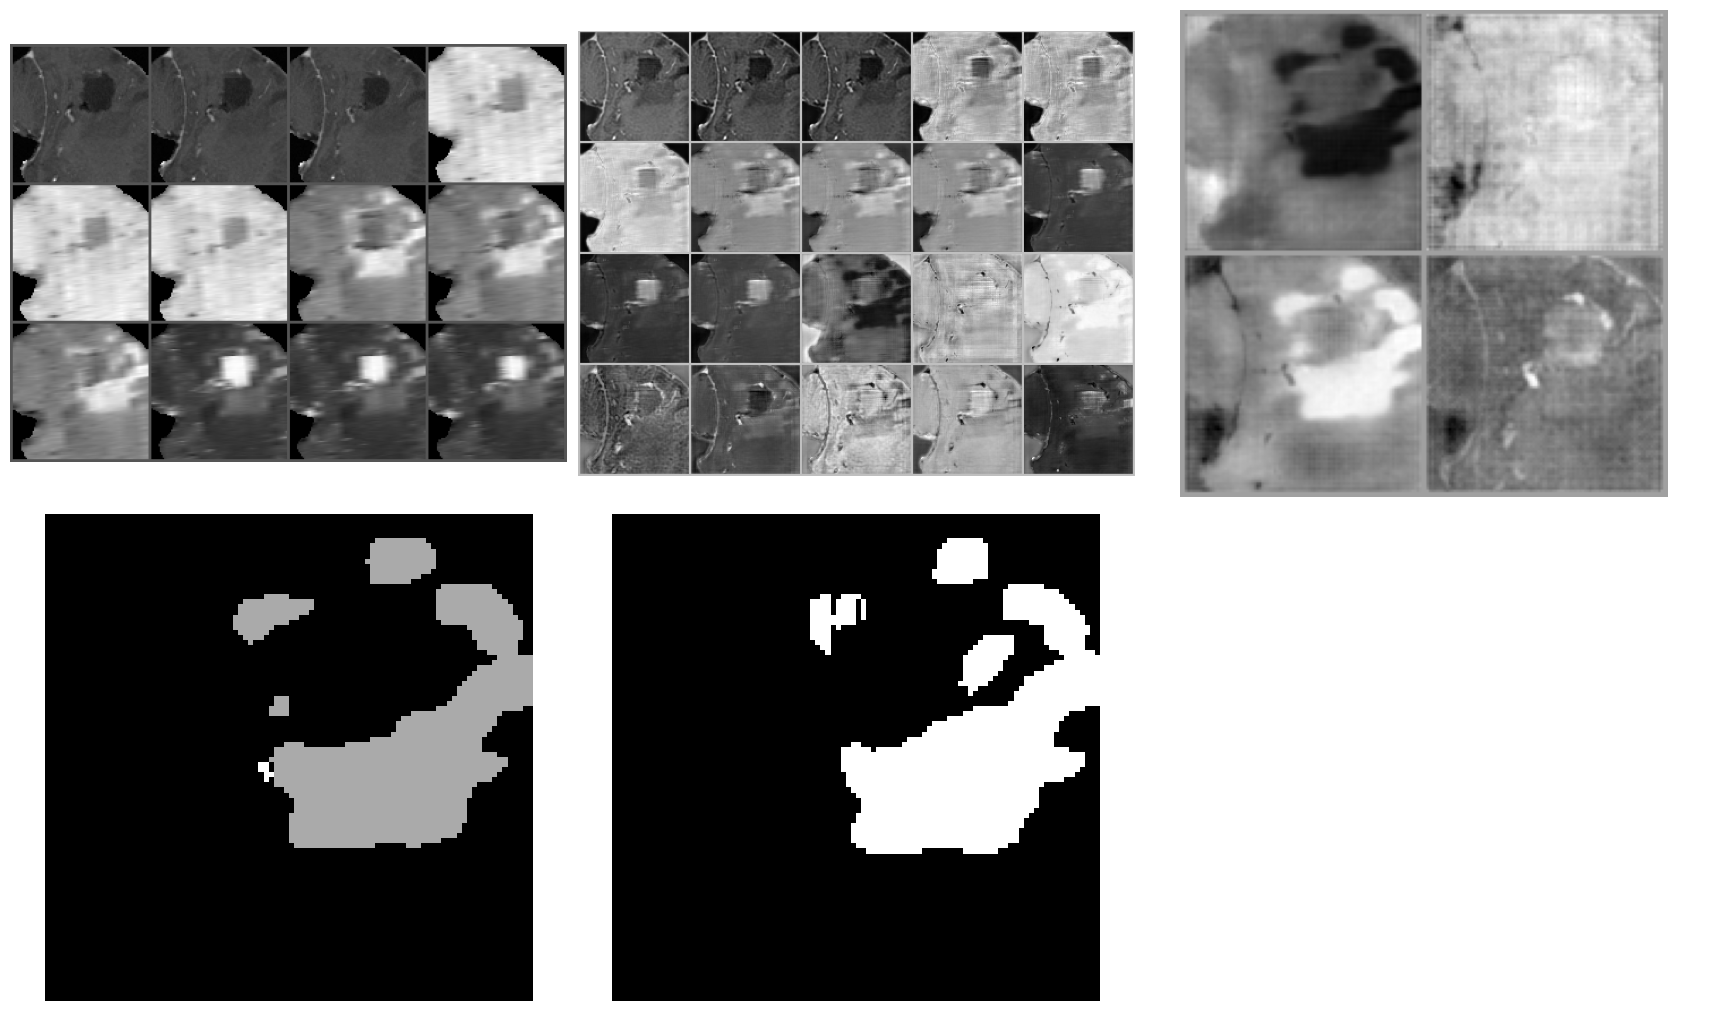

In [114]:
inputs, targets = dstrain[1616]
inputs = inputs.unsqueeze(0)
f = Figure()
preds = learner.inference(inputs)
f.add().imshow_batch(inputs[0], maxelems=100, scale_each=True).style_img()
f.add().imshow_batch(learner.model.context[0], maxelems=100, scale_each=True).style_img()
f.add().imshow_batch(preds[0], maxelems=100, scale_each=True).style_img()
f.add().imshow(preds[0].argmax(0), vmin=0, vmax=3).style_img()
f.add().imshow(targets.argmax(0), vmin=0, vmax=3).style_img()
f.show(figsize=(17,17), nrow=2)